### Reference: Deep Learning by Francois Chollet

### Moving Up to Functional API
Upto now we have used the Sequential Model provided by Keras to build our DL models. Now we will look into features that will allow us to customize Layers, Loss Functions, Model Structure, Training Loops, Evaluation Metrics, Optimizers and basically each and every part of a Deep Learning model. A step up from using the Sequential Model is to use the Functional API provided by Keras which provides far more customizability and flexibility over model architecture. 

#### Example 1

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
inputs = keras.Input(shape=(3,), name="Input Layer")
features = layers.Dense(64, activation="relu", name="Hidden_Dense_RELU")(inputs)
outputs = layers.Dense(10, activation="softmax", name="Output_Dense_Softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

#### Explanation of the Structure 

The Input Layer will take in any batch of samples of variable size where each sample has the shape (3,). If we look at the 'None' value in the output shape of the model summary that implies that the size of batch of samples is undefined and thus it is allowed to take in batches of any size, but still the shape of the samples in the batch matter and are defined.

There is only one Hidden Layer defined in this model, we named it Hidden_Dense_RELU. It is a Dense layer with 64 nodes. Each node performs the same operation of ReLU(WX + b), and each node has randomized initial values for their corressponding W's and b's. It essential to understand how this hidden layer turns out to have 256 trainable parameters. 

The 64 nodes of the Dense hidden layer, each are fed 3 input data, in simpler form, the affine transorfmation each node performs, 

$$
\begin{align*}
A_{node_1}(X) = W_{node_1}X + b_{node_1} \\
\implies A_{node_1}(X) = w_{node_1}^{(1)}x_1 + w_{node_1}^{(2)}x_2 + w_{node_1}^{(3)}x_3 + b_{node_1} 
\end{align*}
$$

Thus each node in the hidden layer is initialized with $4$ trainable parameters, and that is we get $4 \times 64 = 256$ total trainable parameters for the hidden layer.

The last output layer takes $64$ inputs, which are produced by the $64$ nodes of the hidden layer. As the last layer is also a Dense layer with $10$ nodes, each node is initialzied with $64$ weight paramaters and $1$ extra bias parameter. Thus each node is initialized with a total of $65$ trainable parameters. Combined this gives us $10 \times 65 = 650$ trainable parameters for the output layer. 

Summing up all the trainable parameters, we have $256 + 650 = 906$ total trainable parameters for our model. Any loss function defined will have optimize all of these $906$ parameters by calculating the gradient of the loss function with respect to each of the $906$ parameters.

In [3]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(None, 3)]               0         
                                                                 
 Hidden_Dense_RELU (Dense)   (None, 64)                256       
                                                                 
 Output_Dense_Softmax (Dense  (None, 10)               650       
 )                                                               
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


#### Example 2: Leveraging the Actaul Power of the Functional API

Up until now all of the models we made looked like lists, that is had a Sequential pattern. For problems involving multiple input datasets and multiple outputs, the Functional API shows its true power.

This can be illustrated by this hypothetical problem:

Let’s say we are building a system to rank customer support tickets by priority and route them to the appropriate department. Our model has three inputs:
1. The title of the ticket (text input)
2. The text body of the ticket (text input)
3. Any tags added by the user (categorical input, assumed here to be one-hot encoded)

The model also has two outputs:
1. The priority score of the ticket, a scalar between 0 and 1 (sigmoid output)
2. The department that should handle the ticket (a softmax over the set of departments)

This allows us to collect, process and feature engineer each of the relevant input datasets separately, instead of merging them together beforehand and work on them together, which is not always a feasible approach.

Tags are one-hot encoded and text inputs are processed using a vocabulary dictionary, which contains 10000 different words.

A practical example of such a sample would be:

__Ticket__

1. Title: My PC is not turning on. 
2. Text Body : I have bought my pc from your store three months ago. It worked fine until yesterday. Now it's not turning on.
3. Tags: Customer_Service, Technical_Issue

__Departments__ available to forward this ticket are:
1. Customer Service
2. Corporate Division
3. Technical Service
4. Warranty Management Division

Let us assume that our store sells pc's with a warranty of 1 year at minimum for each of its components. That means our model will have to study and identify whether the pc still has warranty left, if it does it may be forwarded to either the Customer Service department or the Technical Service department. But as the text body doesn't indicate any concrete evidence of proper technical malfunctionality, we would want this ticket to go to Customer Service first, so that they can properly diagnose the problem and decide whether it warrants Technical Service.

The Functional API implements this model as below:

In [4]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation="relu")(features)

priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features)

model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

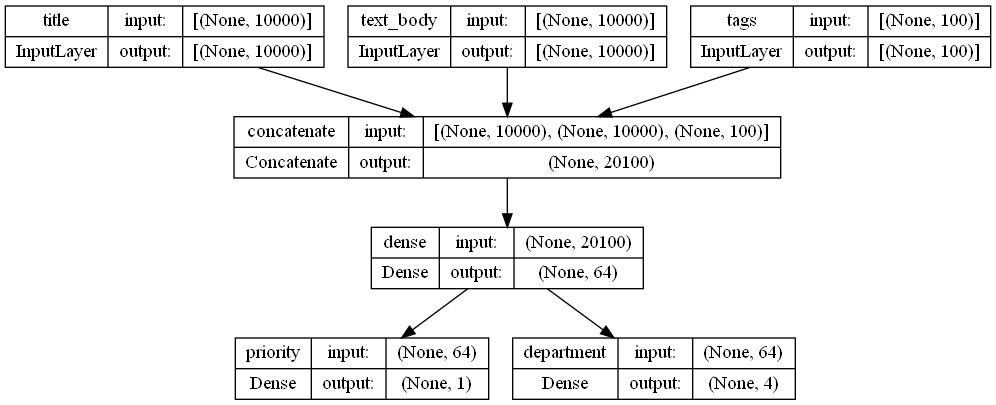

In [6]:
keras.utils.plot_model(model, show_shapes=True)

As we can see this is a very different approach from what a Sequential model does or is capable of.

In [7]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None, 10000)]      0           []                               
                                                                                                  
 text_body (InputLayer)         [(None, 10000)]      0           []                               
                                                                                                  
 tags (InputLayer)              [(None, 100)]        0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 20100)        0           ['title[0][0]',                  
                                                                  'text_body[0][0]',        